# ML Answers

- **Answer Set**: No. 04
- **Full Name**: Mohammad Hosein Nemati
- **Student Code**: `610300185`

---

## Basics

In this section we will done some basic steps:

### Libraries

Before begin, we must import these required libraries:

In [318]:
import abc as abc
import numpy as np
import scipy.io as sp
import matplotlib.pyplot as plt
import sklearn.discriminant_analysis as sklda

### Dataset

Now we can load our dataset:

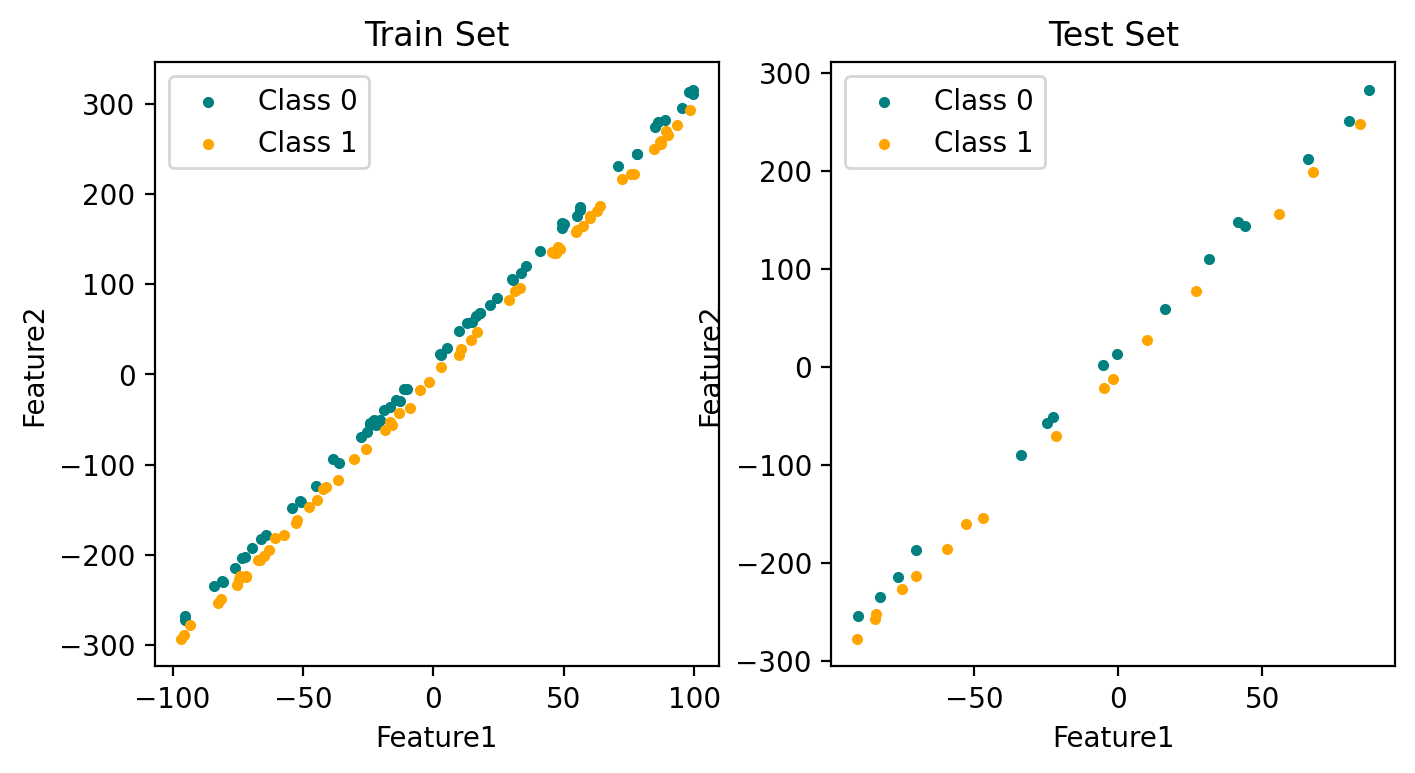

In [319]:
with open("../lib/train_set.npy", "rb") as file:
    train_features = np.load(file)
    train_labels = np.load(file)
    train_labels[train_labels == 0] = -1
    train_class_0 = np.array([
        train_features[i] for i in range(len(train_labels)) if train_labels[i] == -1
    ]).T
    train_class_1 = np.array([
        train_features[i] for i in range(len(train_labels)) if train_labels[i] == 1
    ]).T

with open("../lib/test_set.npy", "rb") as file:
    test_features = np.load(file)
    test_labels = np.load(file)
    test_labels[test_labels == 0] = -1
    test_class_0 = np.array([
        test_features[i] for i in range(len(test_labels)) if test_labels[i] == -1
    ]).T
    test_class_1 = np.array([
        test_features[i] for i in range(len(test_labels)) if test_labels[i] == 1
    ]).T

fig = plt.figure(figsize=(8, 4), dpi=200)

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(train_class_0[0], train_class_0[1], label="Class 0", marker=".", c="teal")
ax1.scatter(train_class_1[0], train_class_1[1], label="Class 1", marker=".", c="orange")
ax1.set_title("Train Set")
ax1.set_xlabel("Feature1")
ax1.set_ylabel("Feature2")
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(test_class_0[0], test_class_0[1], label="Class 0", marker=".", c="teal")
ax2.scatter(test_class_1[0], test_class_1[1], label="Class 1", marker=".", c="orange")
ax2.set_title("Test Set")
ax2.set_xlabel("Feature1")
ax2.set_ylabel("Feature2")
ax2.legend()

plt.show()

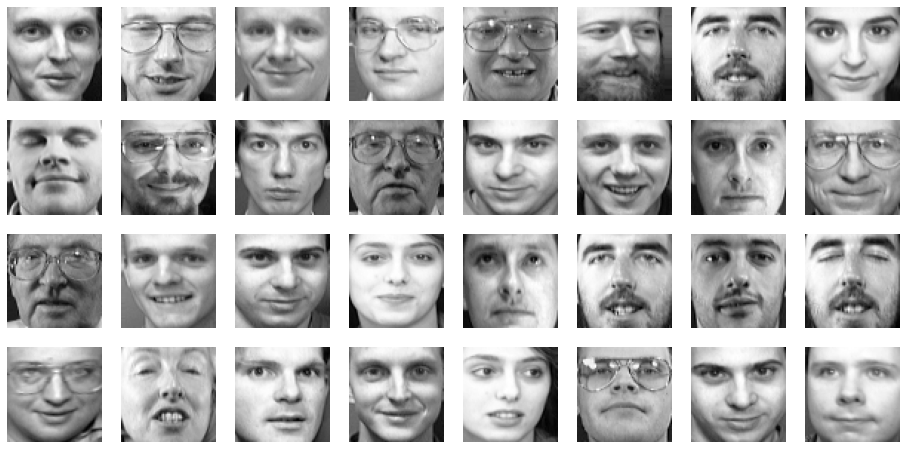

In [320]:
faces_set = sp.loadmat("../lib/faces.mat")["faces"].T

np.random.shuffle(faces_set)

train_faces = faces_set[0:280, :]
test_faces = faces_set[280:-1, :]

faces_images = train_faces.reshape(280, 64, 64)

fig = plt.figure(figsize=(16, 8))

for i in range(8):
    for j in range(4):
        ax = fig.add_subplot(4, 8, (i * 4) + j + 1)
        ax.imshow(faces_images[i * 8 + j].T, cmap="gray")
        ax.axis("off")

plt.show()


### Pipeline

In this section, we will define a generic framework, useful for creating complex `ML Pipelines`, each pipeline consists of two element types:

- **Transformers**: responsible for transforming data records
  - **Standardizer**: Standardizing Records
  - **PCA**: Unsupervised Dimensionality Reduction
  - **LDA**: Supervised Dimensionality Reduction
  - **PolynomialFeatures**: Generating Polynomial Features
- **Estimator**: responsible for classification or regression
  - **Perceptron**: Perceptron Classifier

In [321]:
class Transformer(abc.ABC):
    @abc.abstractclassmethod
    def fit(self, features, labels):
        pass

    @abc.abstractclassmethod
    def converse(self, features):
        pass

    @abc.abstractclassmethod
    def inverse(self, features):
        pass

class Estimator(abc.ABC):
    @abc.abstractclassmethod
    def fit(self, features, labels):
        pass

    @abc.abstractclassmethod
    def predict(self, features):
        pass

class Pipeline(object):
    def __init__(self, transformers, estimator=None):
        self.transformers = transformers
        self.estimator = estimator

    def fit(self, features, labels):
        result = np.array(features)

        for transformer in self.transformers:
            transformer.fit(result, labels)
            result = transformer.converse(result)
        
        if (self.estimator != None):
            self.estimator.fit(result, labels)

        return self

    def converse(self, features):
        result = np.array(features)

        for transformer in self.transformers:
            result = transformer.converse(result)

        return result

    def inverse(self, features):
        result = np.array(features)

        for transformer in reversed(self.transformers):
            result = transformer.inverse(result)

        return result

    def predict(self, features):        
        return self.estimator.predict(self.converse(features))

    def accuracy(self, features, labels):
        return self.estimator.accuracy(self.converse(features), labels)

### Standard Transformer

In [322]:
class Standardizer(Transformer):
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, features, labels):
        self.mean = np.mean(features, axis=0)
        self.std = np.std(features, axis=0)

        return self

    def converse(self, features):
        return (features - self.mean) / self.std

    def inverse(self, features):
        return (features * self.std) + self.mean

### LDA Transformer

In [323]:
class LDA(Transformer):
    def __init__(self, n_components=1):
        self.lda = sklda.LinearDiscriminantAnalysis(n_components=n_components)

    def fit(self, features, labels):
        self.lda.fit(features, labels)

        return self

    def converse(self, features):
        return self.lda.transform(features)

    def inverse(self, features):
        return None

### PCA Transformer

In [324]:
class PCA(Transformer):
    def __init__(self, n_components=1):
        self.n_components = n_components
        self.components = None

    def fit(self, features, labels):
        covariance_matrix = np.cov(features.T)
    
        eigenValues, eigenVectors = np.linalg.eigh(covariance_matrix)
        idx = eigenValues.argsort()[::-1]
        
        self.components = eigenVectors[:, idx]

        return self

    def converse(self, features):
        return features @ self.components[:, 0:self.n_components]

    def inverse(self, features):
        return features @ self.components[:, 0:self.n_components].T

### PolynomialFeatures Transformer

In [325]:
class PolynomialFeatures(Transformer):
    def __init__(self, degree=1):
        self.degree = degree
        self.coeffs = None

    def fit(self, features, labels):
        def generate_coeffs(degree, index):
            result = []

            if index == len(features[0]) - 1:
                return [[degree]]

            for i in range(degree, -1, -1):
                for coeff in generate_coeffs(degree - i, index + 1):
                    result.append([i] + coeff)

            return result

        self.coeffs = []
        for degree in range(self.degree + 1):
            self.coeffs.extend(generate_coeffs(degree, 0))

        return self

    def converse(self, features):
        columns = features.T

        result = []
        for coeffs in self.coeffs:
            terms = [np.power(columns[index], coeff) for index, coeff in enumerate(coeffs)]
            result.append(np.prod(terms, axis=0))
        
        return np.array(result).T

    def inverse(self, features):
        return features[:, 1:3]   

### Perceptron Estimator

In [326]:
class Perceptron(Estimator):
    def __init__(self, learning_rate=0.001, epoch_count=1000, batch_size=1):
        self.learning_rate = learning_rate
        self.epoch_count = epoch_count
        self.batch_size = batch_size
        self.weights = None
        self.history = None

    def fit(self, features, labels):
        self.weights = np.random.rand(len(features[0]))
        self.history = np.zeros(self.epoch_count)

        data_set = np.append(features, np.array([labels]).T, 1)

        for epoch in range(self.epoch_count):
            np.random.shuffle(data_set)

            batches = [
                data_set[batch * self.batch_size : (batch + 1) * self.batch_size]
                for batch in range(int(len(data_set) / self.batch_size))
            ]

            last_weights = self.weights
            last_accuracy = self.accuracy(data_set[:, :-1], data_set[:, -1])

            for batch in batches:
                gradient = self.gradient(batch[:, :-1], batch[:, -1])
                self.weights = self.weights - self.learning_rate * gradient

            if (self.accuracy(data_set[:, :-1], data_set[:, -1]) < last_accuracy):
                self.weights = last_weights

            self.history[epoch] = self.accuracy(data_set[:, :-1], data_set[:, -1])
        
        return self

    def predict(self, features):
        return np.heaviside(features @ self.weights, 1) * 2 - 1
    
    def accuracy(self, features, labels):
        predicts = self.predict(features)

        costs = predicts * labels
        costs[costs < 0] = 0

        return np.sum(costs) / len(features)
    
    def gradient(self, features, labels):
        predicts = self.predict(features)

        costs = predicts * labels
        costs[costs > 0] = 0
        costs[costs < 0] = 1

        return -(costs * features * labels)[0]

---

## Problem (1)

First we `Standardize` data records:

$$
\begin{aligned}
    & X = \{
        \begin{bmatrix} 0 \\ -1\end{bmatrix},
        \begin{bmatrix} 1 \\  0\end{bmatrix},
        \begin{bmatrix} 2 \\  1\end{bmatrix},
        \begin{bmatrix} 1 \\  1\end{bmatrix},
        \begin{bmatrix}-1 \\  1\end{bmatrix},
        \begin{bmatrix}-1 \\ -1\end{bmatrix},
        \begin{bmatrix}-1 \\ -1\end{bmatrix}
    \}
    \\
    \\
    & \mu(X) = \frac{(
        \begin{bmatrix} 0 \\ -1\end{bmatrix} +
        \begin{bmatrix} 1 \\  0\end{bmatrix} +
        \begin{bmatrix} 2 \\  1\end{bmatrix} +
        \begin{bmatrix} 1 \\  1\end{bmatrix} +
        \begin{bmatrix}-1 \\  1\end{bmatrix} +
        \begin{bmatrix}-1 \\ -1\end{bmatrix} +
        \begin{bmatrix}-1 \\ -1\end{bmatrix}
    )}{7} = \begin{bmatrix}\frac{1}{7} \\ 0\end{bmatrix}
    \\
    \\
    & SD(X) = \begin{bmatrix}1.12 \\ 0.92\end{bmatrix}
    \\
    \\
    & X_{standard} = \frac{X - \mu(X)}{SD(X)} = \{
        \begin{bmatrix}-0.12 \\ -1.08\end{bmatrix},
        \begin{bmatrix} 0.76 \\  0.  \end{bmatrix},
        \begin{bmatrix} 1.65 \\  1.08\end{bmatrix},
        \begin{bmatrix} 0.76 \\  1.08\end{bmatrix},
        \begin{bmatrix}-1.01 \\  1.08\end{bmatrix},
        \begin{bmatrix}-1.01 \\ -1.08\end{bmatrix},
        \begin{bmatrix}-1.01 \\ -1.08\end{bmatrix}
    \}
\end{aligned}
$$

### (1)

Now we find the `Covariance Matrix` for standardized records ($\Sigma$):

$$
\begin{aligned}
    & \Sigma = \begin{bmatrix}
        Cov(X_0, X_0) & Cov(X_0, X_1) \\
        Cov(X_1, X_0) & Cov(X_1, X_1)
    \end{bmatrix} = \begin{bmatrix}
        1.16 & 0.64 \\
        0.64 & 1.16
    \end{bmatrix}
\end{aligned}
$$

Now we find the `Eigen Vectors` and `Eigen Values` for `Covariance Matrix`:

$$
\begin{aligned}
    & EigenVectors(\Sigma) = \{
        \begin{bmatrix}-0.70 \\  0.70\end{bmatrix},
        \begin{bmatrix} 0.70 \\  0.70\end{bmatrix}
    \}
    \\
    & EigenValues(\Sigma) = \{0.52, 1.80\}
\end{aligned}
$$

The descending order of `Eigen Vectors` based on `Eigen Values` are `Principal Components`:

$$
\begin{aligned}
    & PC_1 = \begin{bmatrix} 0.70 \\  0.70\end{bmatrix}
    \\
    & PC_2 = \begin{bmatrix}-0.70 \\  0.70\end{bmatrix}
\end{aligned}
$$

### (2)

Now we can find the projection of data on `PC1` vector:

$$
\begin{aligned}
    & X \times PC_1 = \{-0.85, 0.53, 1.93, 1.30, 0.04, -1.48, -1.48\}
\end{aligned}
$$

### (3)

Now we can find the real values using projection of data on `PC1` vector:

$$
\begin{aligned}
    & X' = Projections \times PC_1^T = \{
        \begin{bmatrix}-0.60 \\ -0.60\end{bmatrix},
        \begin{bmatrix} 0.38 \\  0.38\end{bmatrix},
        \begin{bmatrix} 1.36 \\  1.36\end{bmatrix},
        \begin{bmatrix} 0.92 \\  0.92\end{bmatrix},
        \begin{bmatrix} 0.03 \\  0.03\end{bmatrix},
        \begin{bmatrix}-1.04 \\ -1.04\end{bmatrix},
        \begin{bmatrix}-1.04 \\ -1.04\end{bmatrix}
    \}
\end{aligned}
$$

### (4)

Now we can plot the records and their projections:

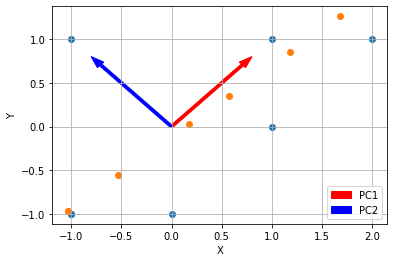

In [327]:
# Define data records
x = np.array([
    [ 0, -1],
    [ 1,  0],
    [ 2,  1],
    [ 1,  1],
    [-1,  1],
    [-1, -1],
    [-1, -1]
])

# Standardize: standardize records
pipe = Pipeline([Standardizer(), PCA(1)]).fit(x, None)

# PCA: Reduce, Increase dimensions
xs = pipe.converse(x)
xs = pipe.inverse(xs)

# Plot records, prjections, pcx
pcx = pipe.transformers[1].components
plt.scatter(x.T[0], x.T[1])
plt.scatter(xs.T[0], xs.T[1])
plt.arrow(0, 0, *pcx[:,0], width=.03, label="PC1", color="red")
plt.arrow(0, 0, *pcx[:,1], width=.03, label="PC2", color="blue")
plt.grid(True, which='both')
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

---

## Problem (2)

In this section, we will use the previously defined `Perceptron` model:

### Plot Function

We will define some functions, for plotting data records:

In [328]:
def plot(figure, index, title, pipeline, features, labels):
    predicts = pipeline.predict(features)
    features = pipeline.converse(features)
    
    # Plot accuracy history
    axis = figure.add_subplot(2, 3, index)
    axis.set_xlabel("Iteration")
    axis.set_ylabel("Accuracy")
    axis.set_title(title)
    history = pipeline.estimator.history
    axis.plot(range(0, len(history)), history)

    # Plot classes scatter
    axis = figure.add_subplot(2, 3, 3 + index)
    axis.set_xlabel("X")
    axis.set_ylabel("Y")
    for label in np.unique(labels):
        class_features = np.array([
            features[i] for i in range(len(labels)) if labels[i] == label
        ]).T
        if (len(class_features) > 2):
            axis.scatter(
                class_features[1],
                class_features[2],
                label=f"Class {label}",
                marker="."
            )
        else:
            axis.scatter(
                class_features[1],
                np.zeros(len(class_features[1])),
                label=f"Class {label}",
                marker="."
            )
    
    # Plot incorrects scatter
    incorrect_features = np.array([
        features[i] for i in range(len(labels)) if labels[i] != predicts[i]
    ]).T
    if (len(incorrect_features) > 0):
        if (len(class_features) > 2):
            axis.scatter(
                incorrect_features[1],
                incorrect_features[2],
                label=f"Incorrects", 
                marker="x", 
                color="red"
            )
        else:
            axis.scatter(
                incorrect_features[1],
                np.zeros(len(incorrect_features[1])),
                label=f"Incorrects", 
                marker="x", 
                color="red"
            )

    # Plot classifier line
    weights = pipeline.estimator.weights
    if (len(weights) == 2):
        y = np.linspace(-300, 300, 1000)
        x = np.zeros(len(y)) + weights[1]
        axis.plot(x, y, color='black', ls='--')
    elif (len(weights) == 3):
        x = np.linspace(-100, 100, 1000)
        f = lambda x: (-weights[1] * x - weights[0]) / weights[2]
        axis.plot(x, f(x), color='black', ls='--')

### Train Models

In this section, we will use our predefined functions for training our models and computing cost values:

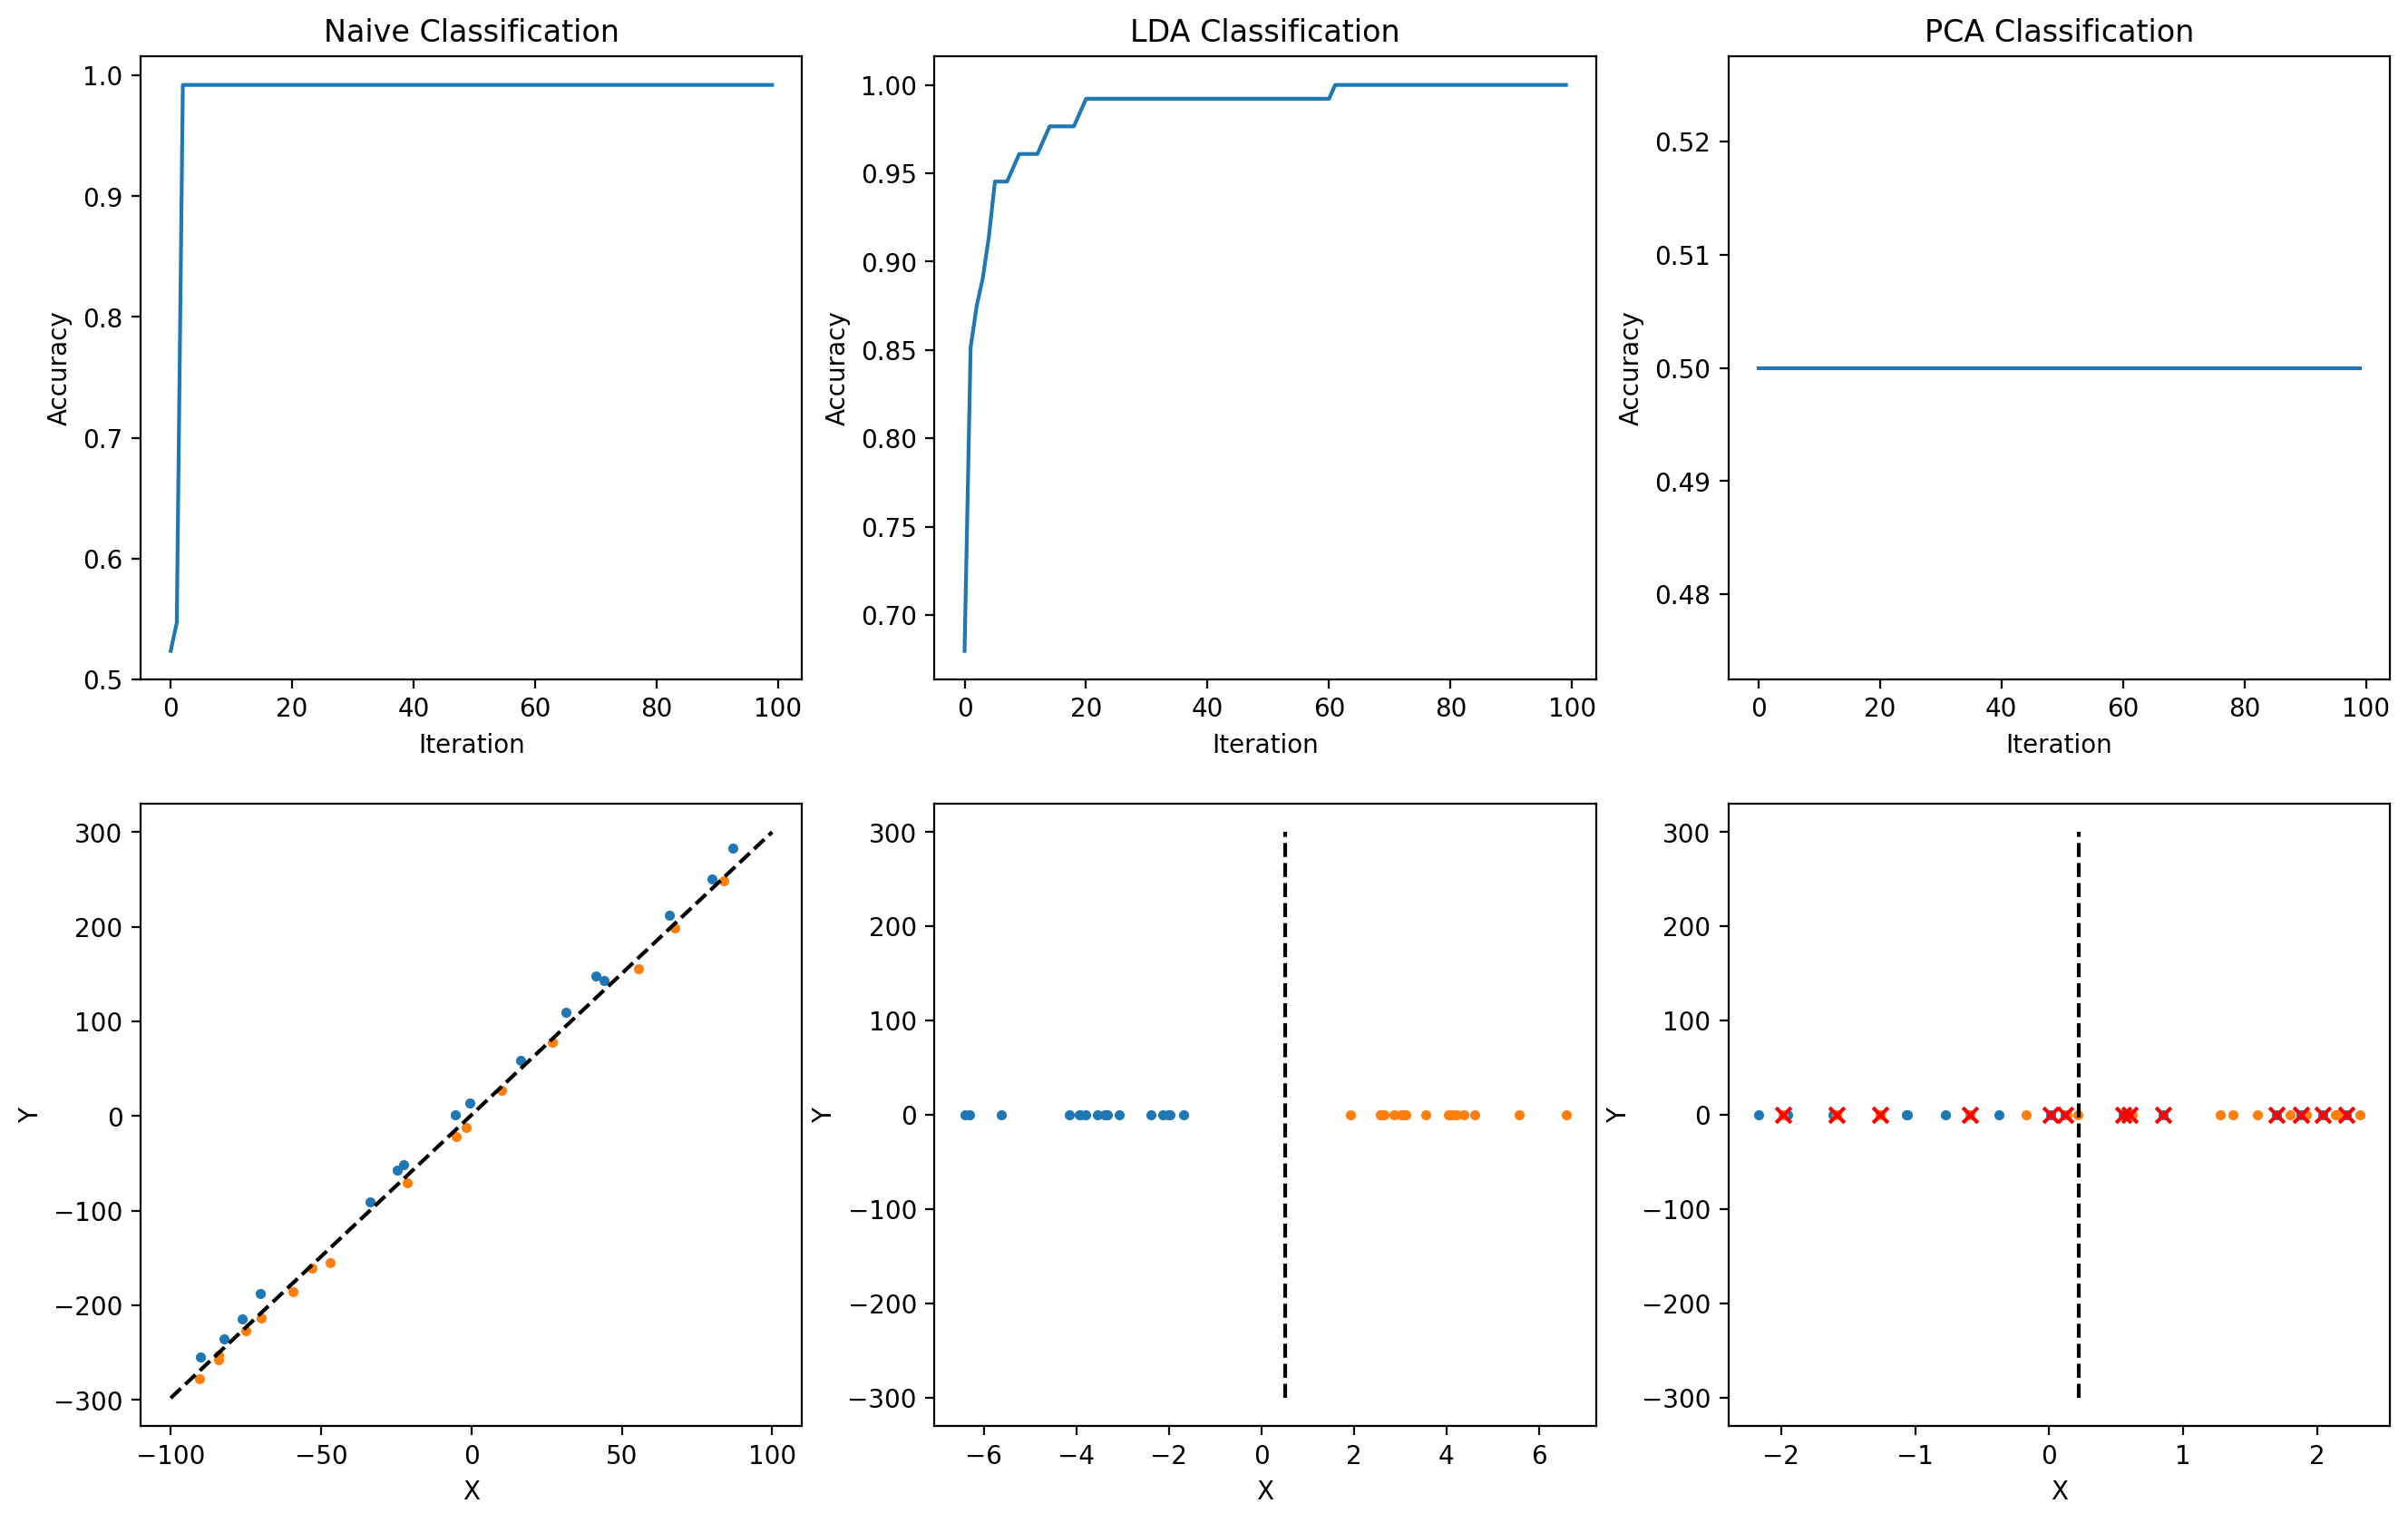

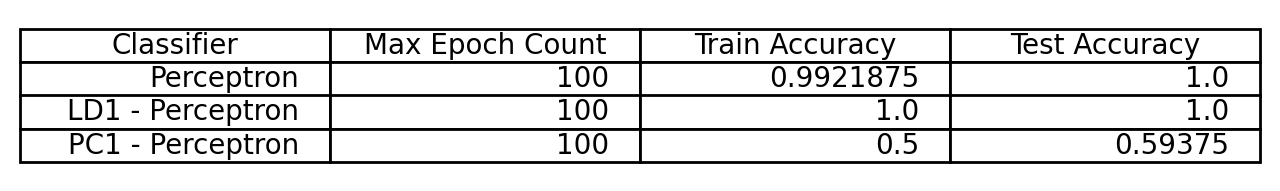

In [329]:
fig = plt.figure(figsize=(16, 10), dpi=200)

# Classify without reducing dimensions
vanilla_pipeline = Pipeline([PolynomialFeatures(1)], Perceptron(epoch_count=100))
vanilla_pipeline.fit(train_features, train_labels)
plot(fig, 1, "Naive Classification", vanilla_pipeline, test_features, test_labels)

# Classify using LD1 component
lda_pipeline = Pipeline([Standardizer(), LDA(1), PolynomialFeatures(1)], Perceptron(epoch_count=100))
lda_pipeline.fit(train_features, train_labels)
plot(fig, 2, "LDA Classification", lda_pipeline, test_features, test_labels)

# Classify using PC1 component
pca_pipeline = Pipeline([Standardizer(), PCA(1), PolynomialFeatures(1)], Perceptron(epoch_count=100))
pca_pipeline.fit(train_features, train_labels)
plot(fig, 3, "PCA Classification", pca_pipeline, test_features, test_labels)

plt.show()

plt.figure(figsize=(8, 1), dpi=200)
plt.table(cellText=[
    [
        "Perceptron", "100",
        vanilla_pipeline.accuracy(train_features, train_labels),
        vanilla_pipeline.accuracy(test_features, test_labels)
    ],
    [
        "LD1 - Perceptron", "100",
        lda_pipeline.accuracy(train_features, train_labels),
        lda_pipeline.accuracy(test_features, test_labels)
    ],
    [
        "PC1 - Perceptron", "100",
        pca_pipeline.accuracy(train_features, train_labels),
        pca_pipeline.accuracy(test_features, test_labels)
    ],
], colLabels=["Classifier", "Max Epoch Count", "Train Accuracy", "Test Accuracy"], loc='center')
plt.axis("off")
plt.show()

### Results

As we can see, the accuracy of **Vanilla Perceptron** and **LD1 Perceptron** is `100%`, because the records are **Linearly Separable**, but the accuracy of **PCA Perceptron** is about `50%`, because it considers the direction in which the variance of the data is greater, not the direction in which classes are separable.

---

## Problem (3)

First we will create a pipeline consists of a **Standardizer** and **PCA**:

In [330]:
pipe = Pipeline([Standardizer(), PCA(1)]).fit(train_faces, None)

### (1)

Now we will set the **PCA** components to `45` and find the projection of data records:

RMSE using 45 components: 952.9992927535747


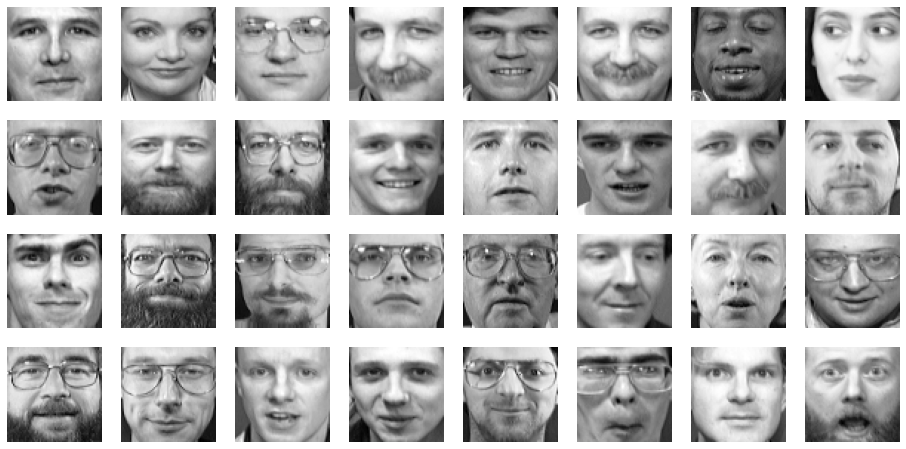

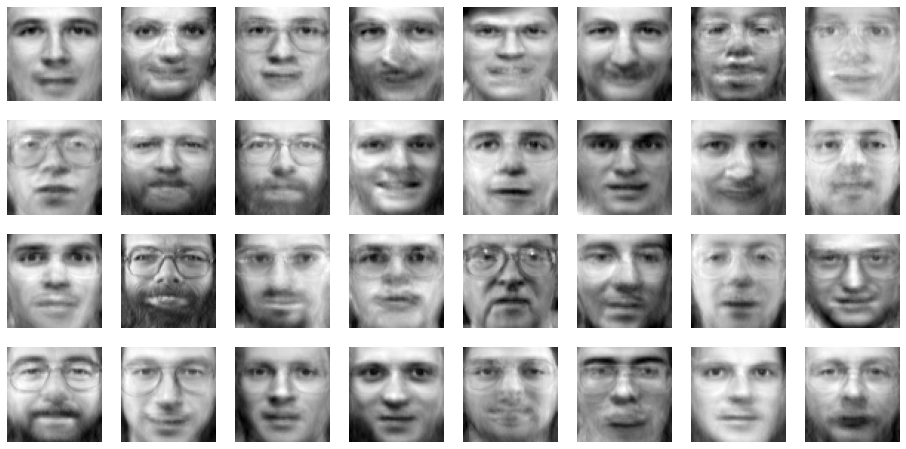

In [331]:
pipe.transformers[1].n_components = 45

compressed_faces = pipe.inverse(pipe.converse(test_faces))

rmse = np.linalg.norm(compressed_faces - test_faces) / np.sqrt(len(test_faces))
print(f"RMSE using 45 components: {rmse}")

fig = plt.figure(figsize=(16, 8))
for i in range(8):
    for j in range(4):
        ax = fig.add_subplot(4, 8, (i * 4) + j + 1)
        ax.imshow(test_faces[i * 8 + j].reshape(64,64).T, cmap="gray")
        ax.axis("off")
plt.show()


fig = plt.figure(figsize=(16, 8))
for i in range(8):
    for j in range(4):
        ax = fig.add_subplot(4, 8, (i * 4) + j + 1)
        ax.imshow(compressed_faces[i * 8 + j].reshape(64,64).T, cmap="gray")
        ax.axis("off")
plt.show()

### (2)

Now, we will iteratively increase the number of components in **PCA** and find the **RMSE** until we get a number less than `1` for **Train Features**:

RMSE using 280 components: 666.1994891279287


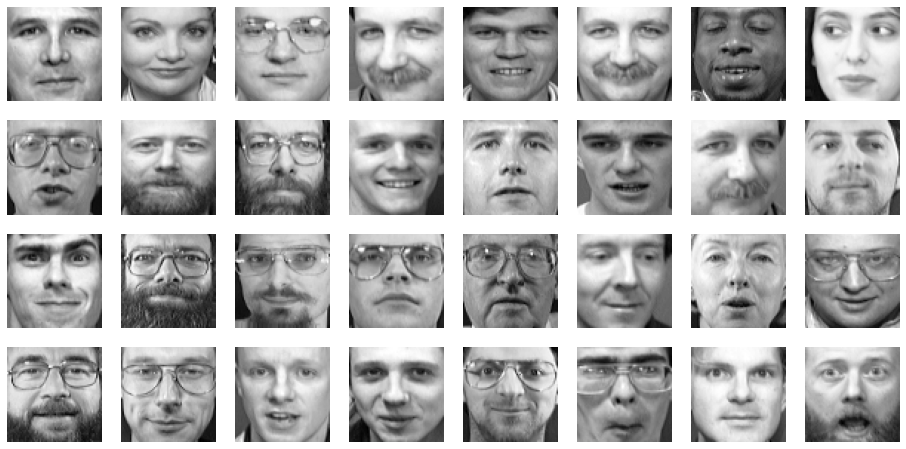

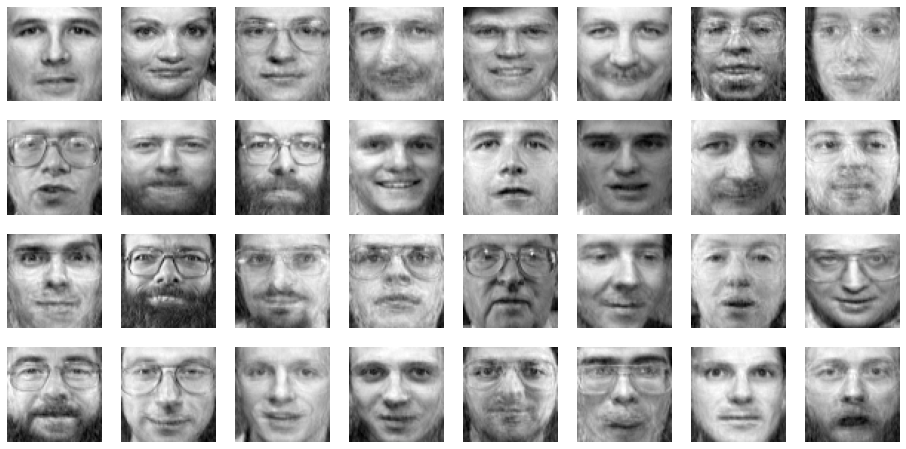

In [332]:
def find_best_number_of_components():
    for i in range(1, 400):
        pipe.transformers[1].n_components = i * 10
        compressed_faces = pipe.inverse(pipe.converse(train_faces))
        
        rmse = np.linalg.norm(compressed_faces - train_faces) / np.sqrt(len(train_faces))
        if rmse < 1:
            return i*10

    return 4000

best = find_best_number_of_components()
pipe.transformers[1].n_components = best
compressed_faces = pipe.inverse(pipe.converse(test_faces))

rmse = np.linalg.norm(compressed_faces - test_faces) / np.sqrt(len(test_faces))
print(f"RMSE using {best} components: {rmse}")

fig = plt.figure(figsize=(16, 8))
for i in range(8):
    for j in range(4):
        ax = fig.add_subplot(4, 8, (i * 4) + j + 1)
        ax.imshow(test_faces[i * 8 + j].reshape(64,64).T, cmap="gray")
        ax.axis("off")
plt.show()


fig = plt.figure(figsize=(16, 8))
for i in range(8):
    for j in range(4):
        ax = fig.add_subplot(4, 8, (i * 4) + j + 1)
        ax.imshow(compressed_faces[i * 8 + j].reshape(64,64).T, cmap="gray")
        ax.axis("off")
plt.show()

### Results

As we can see, the **First Best** number of components is `280` with **RMSE** for **Train Set** less than `1`.

---

## Problem (4)

### Results

As we can see, **LD1** vector is equals to the `Eigen Vector` related to `Maximum Eigen Value` which is $\begin{bmatrix}1 \\ -0.55\end{bmatrix}$.

---